In [1]:
import uproot, ROOT, glob, os, random
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
from sklearn.metrics import roc_curve, roc_auc_score, auc
from tqdm import tqdm
import pandas as pd
from xgboost import XGBClassifier
import seaborn as sns


# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 12.0,8.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 16.0 # Use 14 point font
sns.set(style="whitegrid")

path = '/eos/user/j/jlai/tau_test/'

Welcome to JupyROOT 6.28/06


In [2]:
!ls /eos/user/j/jlai/tau_test

bdt_training_latest.py
bdt_training.py
combined_data.csv
combined_data.h5
conda_env.txt
ditau_flattened_0.h5
ditau_flattened_10.h5
ditau_flattened_11.h5
ditau_flattened_12.h5
ditau_flattened_1.h5
ditau_flattened_2.h5
ditau_flattened_3.h5
ditau_flattened_4.h5
ditau_flattened_5.h5
ditau_flattened_6.h5
ditau_flattened_7.h5
ditau_flattened_8.h5
ditau_flattened_9.h5
ditau_no_empty.py
gamma_flattened_0.h5
graviton_flattened_M1000.h5
graviton_flattened_M1750.h5
graviton_flattened_M2000.h5
graviton_flattened_M2500.h5
graviton_flattened_M5000.h5
plotter_v4.py
skimmer.py
test.py
user.agarabag.DiJetNewbdt.364701.Pythia8EvtGen_A14NNPDF23LO_jetjet_JZ1WithSW_v1_output.root


In [3]:
branches = ['ditau_pt', 'n_subjets', 'IsTruthHadronic', 'n_tracks_lead', 'n_tracks_subl',
 'R_max_lead', 'R_max_subl', 'R_tracks_subl', 'R_isotrack', 'd0_leadtrack_lead',
 'd0_leadtrack_subl', 'f_core_lead', 'f_core_subl', 'f_subjet_subl', 'f_subjets',
 'f_isotracks', 'm_core_lead', 'm_core_subl', 'm_tracks_lead', 'm_tracks_subl',
 'n_track']

training_vars = [
    "f_core_lead", "f_core_subl", "f_subjet_subl", "f_subjets", "f_isotracks",
    "R_max_lead", "R_max_subl", "R_isotrack", "R_tracks_subl", "m_core_lead",
    "m_core_subl", "m_tracks_lead", "m_tracks_subl", "d0_leadtrack_lead",
    "d0_leadtrack_subl", "n_track", "n_tracks_lead"
]

df = pd.read_csv(path+'combined_data.csv')
df = df[6:] # get rid of jz0 and jz1
df = df[df.f_core_subl != -999] # get rid of outlier
df['weight'] = df['event_weight'] * df['pT_weight']
df

,event_id,ditau_pt,IsTruthHadronic,f_core_lead,f_core_subl,f_subjet_subl,f_subjets,f_isotracks,R_max_lead,R_max_subl,...,d0_leadtrack_subl,n_track,n_tracks_lead,n_tracks_subl,n_subjets,event_weight,bdt_score,pT_weight,label,weight
6,36300348,200720.88,0,0.847755,0.683239,0.084422,0.555999,0.014591,0.027558,0.149601,...,0.022509,5,1,3,3,6.836578e-02,0.610205,2.444456e-04,0,0.000017
7,27674456,249767.81,0,0.809443,0.844066,0.247756,0.625814,0.005726,0.182669,0.010000,...,-0.014537,6,3,1,4,2.085233e-02,0.679975,1.223512e-04,0,0.000003
8,45574018,209212.66,0,0.855507,0.764981,0.295278,0.669263,0.003218,0.060898,0.046829,...,-0.036782,4,1,3,2,1.271062e-02,0.682694,2.444456e-04,0,0.000003
9,42745976,215885.73,0,0.963799,0.667000,0.252668,0.700827,0.008621,0.120004,0.182444,...,0.000000,12,3,1,5,2.134600e-02,0.419487,2.444456e-04,0,0.000005
10,40522366,250142.16,0,0.728881,0.689589,0.396467,0.812390,0.003817,0.194865,0.033817,...,-0.003847,4,3,1,2,9.952256e-02,0.657240,1.223512e-04,0,0.000012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1250003,31163332,526071.20,1,0.910397,0.969296,0.104997,0.943490,0.000000,0.015913,0.023469,...,-0.059134,4,3,1,2,2.144722e-10,0.799701,4.662652e+08,1,0.100001
1250004,30334126,336502.47,1,0.915086,0.163371,0.118368,0.814084,0.003424,0.013215,0.022163,...,-0.051443,5,3,1,3,2.144722e-10,0.716544,9.515616e+07,1,0.020408
1250005,30541837,361832.78,1,0.921741,0.790117,0.321459,0.791638,0.007923,0.008872,0.035717,...,0.030005,4,1,3,2,2.144722e-10,0.747290,1.227014e+08,1,0.026316
1250006,30665541,267720.94,1,0.791846,0.778316,0.255994,0.886948,0.003313,0.014343,0.010908,...,-0.053649,4,3,1,2,2.144722e-10,0.729371,7.173202e+07,1,0.015385


In [4]:
df.describe()

,event_id,ditau_pt,IsTruthHadronic,f_core_lead,f_core_subl,f_subjet_subl,f_subjets,f_isotracks,R_max_lead,R_max_subl,...,d0_leadtrack_subl,n_track,n_tracks_lead,n_tracks_subl,n_subjets,event_weight,bdt_score,pT_weight,label,weight
count,1.250001e+06,1.250001e+06,1.250001e+06,1.250001e+06,1.250001e+06,1.250001e+06,1.250001e+06,1.250001e+06,1.250001e+06,1.250001e+06,...,1.250001e+06,1.250001e+06,1.250001e+06,1.250001e+06,1.250001e+06,1.250001e+06,1.250001e+06,1.250001e+06,1.250001e+06,1.250001e+06
mean,2.073476e+08,4.314831e+05,8.599673e-02,8.598232e-01,4.351379e-01,6.459976e-02,8.185769e-01,1.535391e-02,8.801527e-02,1.161825e-01,...,-2.685822e-04,4.818627e+00,2.784576e+00,1.215424e+00,2.453793e+00,2.448417e-04,5.061150e-01,1.463637e+05,8.598953e-02,9.248986e-05
std,1.541140e+08,1.848540e+05,2.803593e-01,8.018174e-02,2.565048e-01,7.808390e-02,9.088417e-02,5.143370e-02,6.308150e-02,5.708317e-02,...,8.296457e-02,1.882580e+00,6.200327e-01,6.200327e-01,8.112378e-01,1.728348e-03,1.070053e-01,1.595557e+07,2.803487e-01,3.454206e-03
min,1.100000e+01,2.000000e+05,0.000000e+00,7.191471e-03,2.094379e-04,2.818542e-03,9.065603e-02,0.000000e+00,1.995845e-05,5.141489e-05,...,-1.015759e+00,4.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,5.141540e-16,2.653651e-01,1.223512e-04,0.000000e+00,7.057462e-20
25%,7.486472e+07,2.835506e+05,0.000000e+00,8.237005e-01,2.080576e-01,2.565938e-02,7.623764e-01,4.393903e-03,2.783664e-02,7.045868e-02,...,0.000000e+00,4.000000e+00,3.000000e+00,1.000000e+00,2.000000e+00,5.266416e-06,4.261238e-01,1.503699e-02,0.000000e+00,3.004970e-06
50%,1.900003e+08,3.872961e+05,0.000000e+00,8.742300e-01,4.272147e-01,3.605864e-02,8.344137e-01,1.042412e-02,7.588327e-02,1.230879e-01,...,0.000000e+00,4.000000e+00,3.000000e+00,1.000000e+00,2.000000e+00,2.586703e-05,4.895093e-01,3.608175e-01,0.000000e+00,1.732888e-05
75%,2.939791e+08,5.260131e+05,0.000000e+00,9.139876e-01,6.306292e-01,5.891509e-02,8.880830e-01,1.992001e-02,1.476200e-01,1.665299e-01,...,0.000000e+00,5.000000e+00,3.000000e+00,1.000000e+00,3.000000e+00,2.414404e-04,5.648352e-01,5.069307e+00,0.000000e+00,4.427668e-05
max,4.930031e+08,9.999968e+05,1.000000e+00,9.975535e-01,1.000000e+00,5.146357e-01,1.067907e+00,3.191106e+01,2.000000e-01,1.999999e-01,...,1.017063e+00,4.800000e+01,3.000000e+00,3.000000e+00,1.600000e+01,1.437270e+00,8.212081e-01,4.662652e+09,1.000000e+00,1.000032e+00


In [5]:
from sklearn.preprocessing import StandardScaler

# normalize the data
scaler = StandardScaler()

df[training_vars] = scaler.fit_transform(df[training_vars])

df.describe()

,event_id,ditau_pt,IsTruthHadronic,f_core_lead,f_core_subl,f_subjet_subl,f_subjets,f_isotracks,R_max_lead,R_max_subl,...,d0_leadtrack_subl,n_track,n_tracks_lead,n_tracks_subl,n_subjets,event_weight,bdt_score,pT_weight,label,weight
count,1.250001e+06,1.250001e+06,1.250001e+06,1.250001e+06,1.250001e+06,1.250001e+06,1.250001e+06,1.250001e+06,1.250001e+06,1.250001e+06,...,1.250001e+06,1.250001e+06,1.250001e+06,1.250001e+06,1.250001e+06,1.250001e+06,1.250001e+06,1.250001e+06,1.250001e+06,1.250001e+06
mean,2.073476e+08,4.314831e+05,8.599673e-02,-9.371426e-16,1.455190e-18,5.529723e-17,1.698935e-16,1.155057e-16,6.912154e-17,-9.014904e-16,...,-7.241846e-18,2.011119e-16,1.513398e-16,1.215424e+00,2.453793e+00,2.448417e-04,5.061150e-01,1.463637e+05,8.598953e-02,9.248986e-05
std,1.541140e+08,1.848540e+05,2.803593e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,6.200327e-01,8.112378e-01,1.728348e-03,1.070053e-01,1.595557e+07,2.803487e-01,3.454206e-03
min,1.100000e+01,2.000000e+05,0.000000e+00,-1.063374e+01,-1.695597e+00,-7.912161e-01,-8.009328e+00,-2.985186e-01,-1.394947e+00,-2.034420e+00,...,-1.224005e+01,-4.348431e-01,-2.878198e+00,1.000000e+00,2.000000e+00,5.141540e-16,2.653651e-01,1.223512e-04,0.000000e+00,7.057462e-20
25%,7.486472e+07,2.835506e+05,0.000000e+00,-4.505100e-01,-8.852872e-01,-4.986994e-01,-6.183751e-01,-2.130901e-01,-9.539827e-01,-8.010043e-01,...,3.237313e-03,-4.348431e-01,3.474396e-01,1.000000e+00,2.000000e+00,5.266416e-06,4.261238e-01,1.503699e-02,0.000000e+00,3.004970e-06
50%,1.900003e+08,3.872961e+05,0.000000e+00,1.796774e-01,-3.088883e-02,-3.655187e-01,1.742528e-01,-9.584754e-02,-1.923227e-01,1.209699e-01,...,3.237313e-03,-4.348431e-01,3.474396e-01,1.000000e+00,2.000000e+00,2.586703e-05,4.895093e-01,3.608175e-01,0.000000e+00,1.732888e-05
75%,2.939791e+08,5.260131e+05,0.000000e+00,6.755212e-01,7.621356e-01,-7.280212e-02,7.647777e-01,8.877638e-02,9.448846e-01,8.820007e-01,...,3.237313e-03,9.634306e-02,3.474396e-01,1.000000e+00,3.000000e+00,2.414404e-04,5.648352e-01,5.069307e+00,0.000000e+00,4.427668e-05
max,4.930031e+08,9.999968e+05,1.000000e+00,1.717728e+00,2.202152e+00,5.763494e+00,2.743385e+00,6.201327e+02,1.775239e+00,1.468338e+00,...,1.226225e+01,2.293735e+01,3.474396e-01,3.000000e+00,1.600000e+01,1.437270e+00,8.212081e-01,4.662652e+09,1.000000e+00,1.000032e+00


17it [00:01, 13.09it/s]


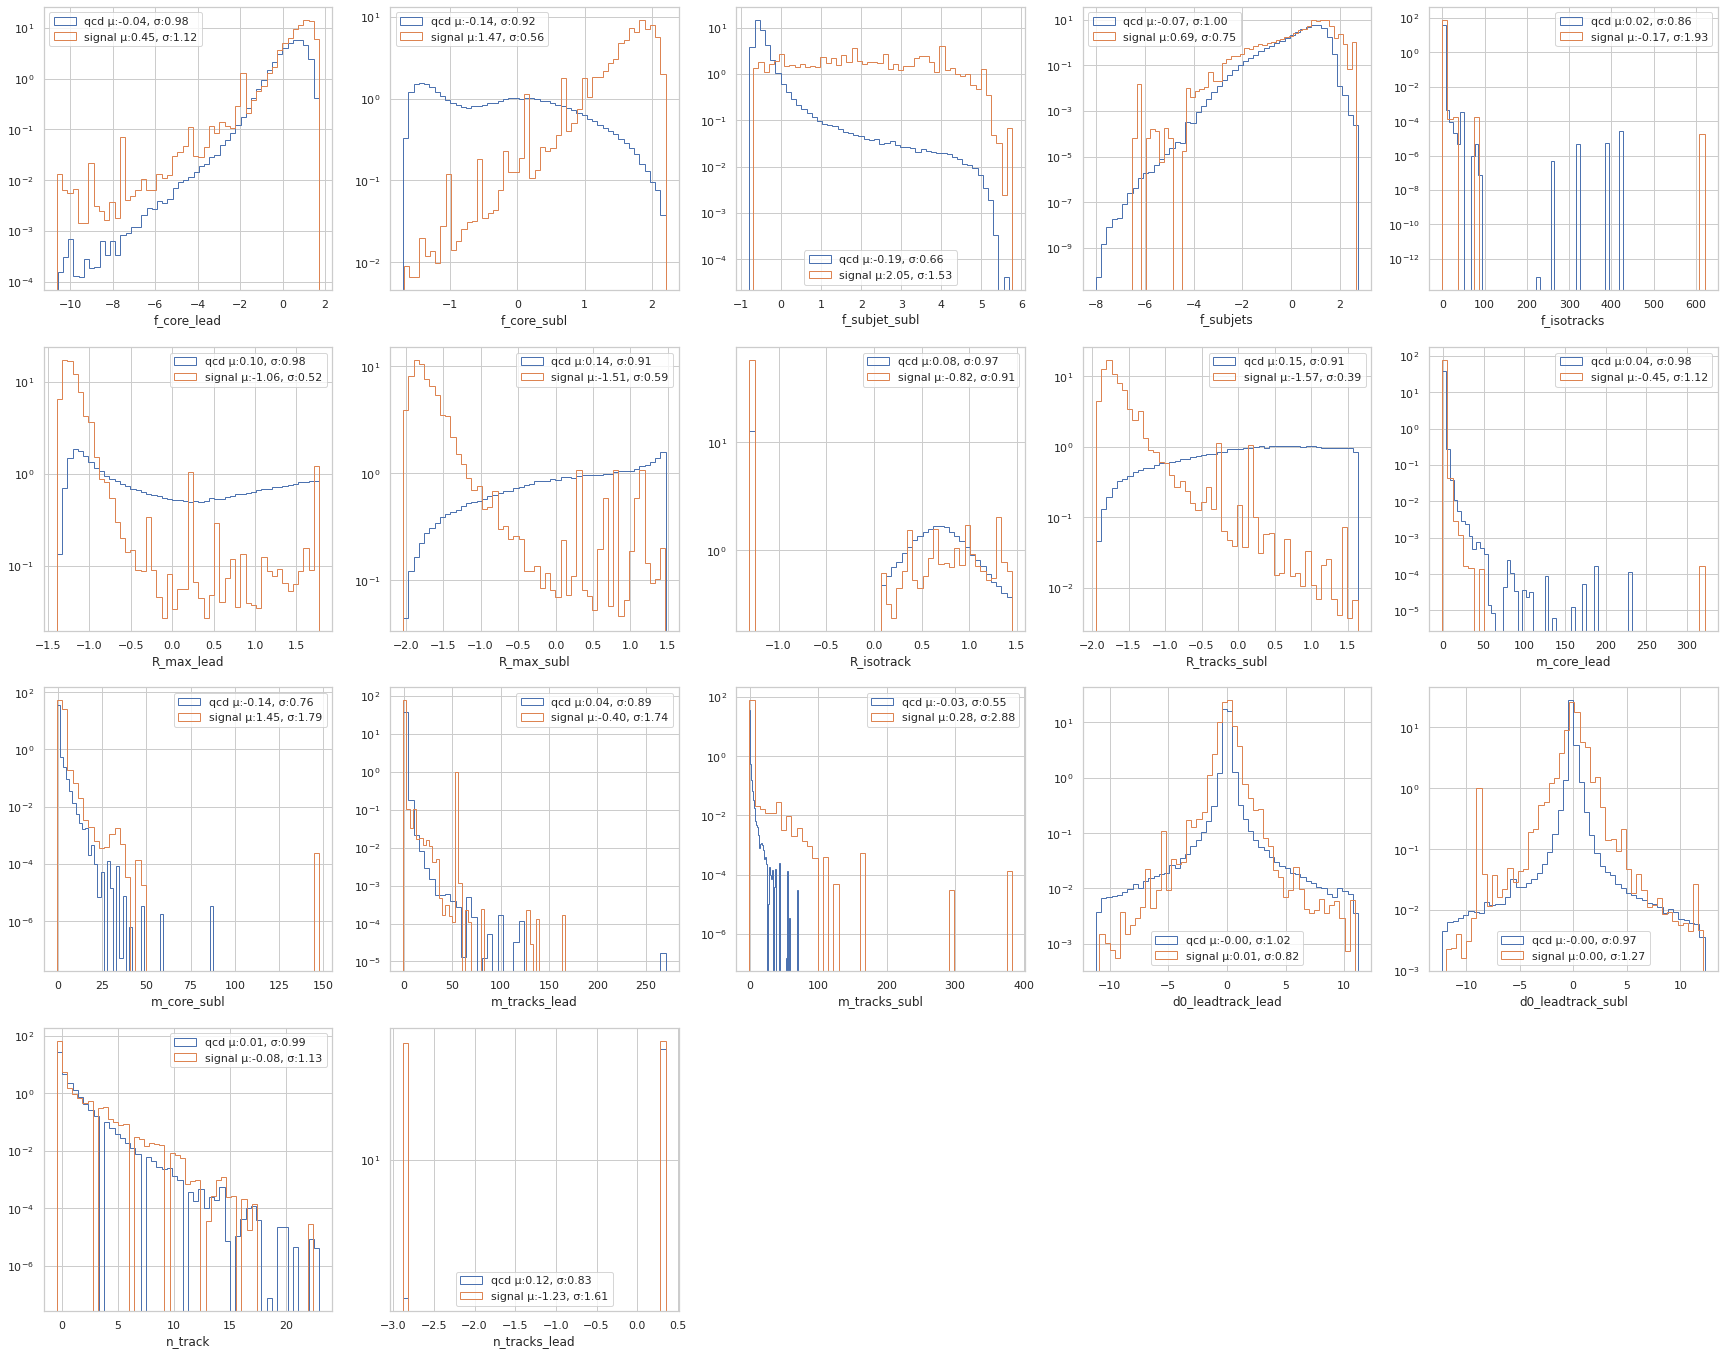

In [6]:
# Plot the Transformed Training Vars
signal = df[df.label==1]
bkg = df[df.label==0]

plt.figure(figsize=(30, 24))
def hist(variable, plot_num):
    plt.subplot(4, 5, plot_num)
    bin = 50
    plt.hist(bkg[variable], bins=bin, histtype='step', linewidth=1, weights=bkg['weight'], label=f'qcd μ:{np.mean(bkg[variable]):.2f}, σ:{np.std(bkg[variable]):.2f}')
    plt.hist(signal[variable], bins=bin, histtype='step', linewidth=1, weights=signal['weight'], label=f'signal μ:{np.mean(signal[variable]):.2f}, σ:{np.std(signal[variable]):.2f}')
    plt.xlabel(variable)
    plt.yscale('log')
    plt.legend()
    plt.grid(True)

for i, label in tqdm(enumerate(training_vars, 1)):
    hist(label, i)

Epoch 1/50, Training Loss: 1.3271e-05, Validation Loss: 6.8976e-06, Training Accuracy: 9.3166e-01, Validation Accuracy: 9.3499e-01
Epoch 2/50, Training Loss: 1.0758e-05, Validation Loss: 8.9807e-06, Training Accuracy: 9.4464e-01, Validation Accuracy: 9.2638e-01
Epoch 3/50, Training Loss: 9.3393e-06, Validation Loss: 6.2364e-06, Training Accuracy: 9.4466e-01, Validation Accuracy: 9.4467e-01
Epoch 4/50, Training Loss: 1.0008e-05, Validation Loss: 7.7536e-06, Training Accuracy: 9.4304e-01, Validation Accuracy: 9.4690e-01
Epoch 5/50, Training Loss: 7.7759e-06, Validation Loss: 6.5818e-06, Training Accuracy: 9.5319e-01, Validation Accuracy: 9.5703e-01
Epoch 6/50, Training Loss: 8.1153e-06, Validation Loss: 6.1538e-06, Training Accuracy: 9.5061e-01, Validation Accuracy: 9.4335e-01
Epoch 7/50, Training Loss: 6.4432e-06, Validation Loss: 6.2637e-06, Training Accuracy: 9.5423e-01, Validation Accuracy: 9.5537e-01
Epoch 8/50, Training Loss: 8.3602e-06, Validation Loss: 5.9459e-06, Training Accura

/tmp/ipykernel_460/1773607920.py:206: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr, 1/fpr, color='black', lw=1, label='ROC curve (area = %0.5f)' % roc_auc)


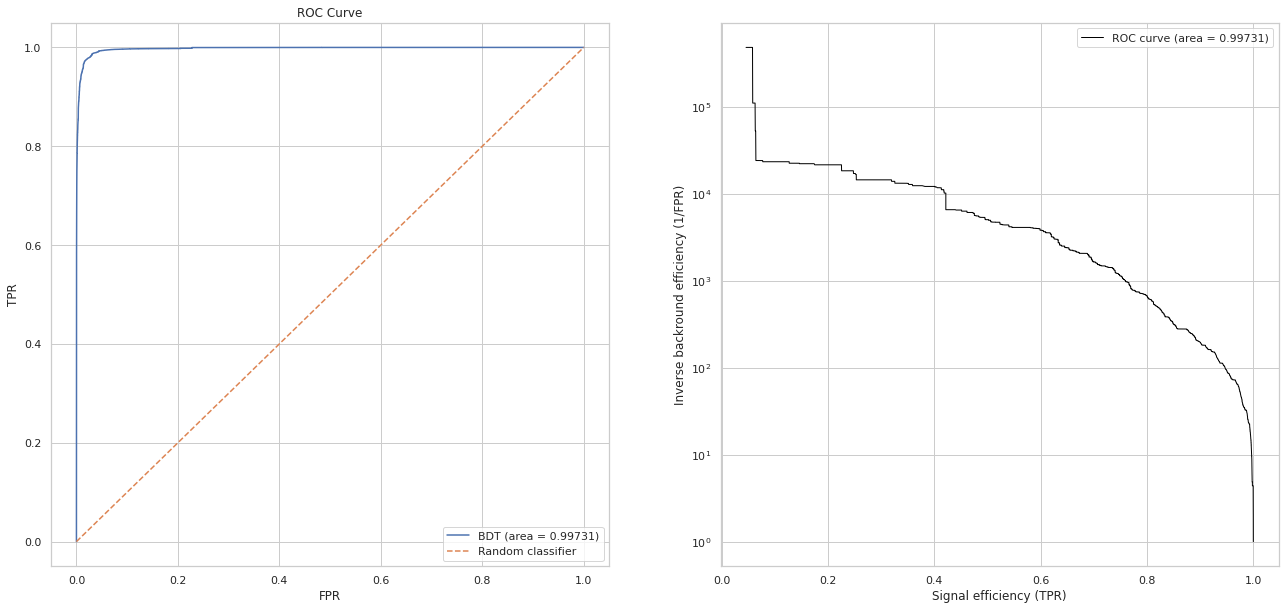

Pytorch Time: 30.00763546625773 min


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

start = time.time()

learning_rate = 0.0005
batch_size = 64
dropout = 0
neuron1 = 256
neuron2 = 1024
neuron3 = 512
neuron4 = 128
neuron5 = 32

# features = df[training_vars].values
# labels = df['label'].values
# weights = df['weight'].values

# # Split the dataset into training and validation sets
# X_train, X_val, y_train, y_val, weights_train, weights_val = train_test_split(
#     features, labels, weights, test_size=0.2, random_state=42)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Split the dataset into training and validation sets
df['eventID_mod'] = df['event_id'] % 10

train_loc = df['eventID_mod'] < 7 # 70%
test_loc = df['eventID_mod'] >= 7 # 30%

features, labels, weights = df[training_vars].values, df['label'].values, df['weight'].values

X_train, X_val, y_train, y_val, weights_train, weights_val = \
      features[train_loc], features[test_loc], labels[train_loc], labels[test_loc], weights[train_loc], weights[test_loc] 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
weights_train_tensor = torch.tensor(weights_train, dtype=torch.float32).to(device)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

# Define the Dataset
class SignalBackgroundDataset(Dataset):
    def __init__(self, features, labels, weights):
        self.features = features
        self.labels = labels
        self.weights = weights

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx], self.weights[idx]

# Define the DNN model with dropout
class DNN(nn.Module):
    def __init__(self, input_size):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_size, neuron1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(neuron1, neuron2)
        self.fc3 = nn.Linear(neuron2, neuron3)
        self.fc4 = nn.Linear(neuron3, neuron4)
        self.fc5 = nn.Linear(neuron4, neuron5)
        self.fc6 = nn.Linear(neuron5, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.relu(self.fc5(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc6(x))
        return x

model = DNN(X_train_tensor.shape[1]).to(device)
criterion = nn.BCELoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create DataLoader for training data
train_dataset = SignalBackgroundDataset(X_train_tensor, y_train_tensor, weights_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = SignalBackgroundDataset(X_val_tensor, y_val_tensor, torch.tensor(weights_val, dtype=torch.float32).to(device))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 50
patience = 6  # How many epochs to wait after last time validation loss improved.
best_val_loss = np.inf  # Initialize best validation loss to infinity
epochs_no_improve = 0  # Counter for epochs with no improvement

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions, total_predictions = 0, 0

    for inputs, targets, batch_weights in train_loader:
        inputs, targets, batch_weights = inputs.to(device), targets.to(device), batch_weights.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss = (loss * batch_weights).mean()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # binary classification for accuracy calculation
        preds = outputs.squeeze().round()
        correct_predictions += (preds == targets).sum().item()
        total_predictions += targets.size(0)

    train_accuracy = correct_predictions / total_predictions
    avg_training_loss = running_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    correct_predictions, total_predictions = 0, 0

    with torch.no_grad():
        for inputs, targets, batch_weights in val_loader:
            inputs, targets, batch_weights = inputs.to(device), targets.to(device), batch_weights.to(device)

            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss = (loss * batch_weights).mean()

            val_running_loss += loss.item()

            preds = outputs.squeeze().round()
            correct_predictions += (preds == targets).sum().item()
            total_predictions += targets.size(0)

    val_accuracy = correct_predictions / total_predictions
    avg_val_loss = val_running_loss / len(val_loader)

#     # Log metrics to W&B
#     wandb.log({
#         'epoch': epoch,
#         'training_loss': avg_training_loss,
#         'validation_loss': avg_val_loss,
#         'training_accuracy': train_accuracy,
#         'validation_accuracy': val_accuracy
#     })

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_training_loss:.4e}, Validation Loss: {avg_val_loss:.4e}, Training Accuracy: {train_accuracy:.4e}, Validation Accuracy: {val_accuracy:.4e}")

    # Check if the validation loss improved
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # Save the model
        # torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs.')
            break  # Early stopping


# Evaluate on the validation set
model.eval()
val_predictions = []
with torch.no_grad():
    for inputs, targets, _ in DataLoader(SignalBackgroundDataset(X_val_tensor, y_val_tensor, torch.tensor(weights_val, dtype=torch.float32)), batch_size=batch_size, shuffle=False):
        inputs = inputs.to(device)
        outputs = model(inputs).squeeze()
        val_predictions.extend(outputs.cpu().numpy())
val_predictions = np.array(val_predictions)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_val, val_predictions, sample_weight=weights_val)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(22, 10))
plt.subplot(121)
plt.plot(fpr, tpr, label='BDT (area = {:.5f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)

plt.subplot(122)
plt.plot(tpr, 1/fpr, color='black', lw=1, label='ROC curve (area = %0.5f)' % roc_auc)
plt.xlabel('Signal efficiency (TPR)')
plt.ylabel('Inverse backround efficiency (1/FPR)')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

print(f'Pytorch Time: {(time.time() - start)/60} min')

In [7]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

learning_rate = 0.0005
batch_size = 64
dropout = 0
neuron1 = 256
neuron2 = 1024
neuron3 = 512
neuron4 = 128
neuron5 = 32

# features = df[training_vars].values
# labels = df['label'].values
# weights = df['weight'].values

# # Split the dataset into training and validation sets
# X_train, X_val, y_train, y_val, weights_train, weights_val = train_test_split(
#     features, labels, weights, test_size=0.2, random_state=42)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Split the dataset into training and validation sets
df['eventID_mod'] = df['event_id'] % 10

train_loc = df['eventID_mod'] < 7 # 70%
test_loc = df['eventID_mod'] >= 7 # 30%

features, labels, weights = df[training_vars].values, df['label'].values, df['weight'].values

X_train, X_val, y_train, y_val, weights_train, weights_val = \
      features[train_loc], features[test_loc], labels[train_loc], labels[test_loc], weights[train_loc], weights[test_loc] 


# Model configuration
input_shape = X_train.shape[1]  # Assuming X_train is a 2D array; adjust accordingly
learning_rate = 0.0005
batch_size = 64
epochs = 100  # Set a maximum number of epochs
dropout_rate = 0  # No dropout in this case
neurons = [256, 1024, 512, 128, 32]  # Neurons in each layer

# Define the model
model = Sequential()
model.add(Dense(neurons[0], input_shape=(input_shape,), activation='relu'))
for neuron in neurons[1:]:
    model.add(Dense(neuron, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification; adjust the activation and units as necessary

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='binary_crossentropy', 
              metrics=['accuracy'],
              weighted_metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    sample_weight=weights_train, 
                    validation_data=(X_val, y_val, weights_val), 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping],
                    verbose=1)


Epoch 1/100
13673/13673 [==============================] - 255s 18ms/step - loss: 1.5595e-05 - accuracy: 0.9283 - weighted_accuracy: 0.9450 - val_loss: 6.6458e-06 - val_accuracy: 0.9476 - val_weighted_accuracy: 0.9748
Epoch 2/100
13673/13673 [==============================] - 90s 7ms/step - loss: 1.1575e-05 - accuracy: 0.9380 - weighted_accuracy: 0.9621 - val_loss: 7.2063e-06 - val_accuracy: 0.9472 - val_weighted_accuracy: 0.9747
Epoch 3/100
13673/13673 [==============================] - 89s 7ms/step - loss: 1.0894e-05 - accuracy: 0.9433 - weighted_accuracy: 0.9610 - val_loss: 6.9645e-06 - val_accuracy: 0.9594 - val_weighted_accuracy: 0.9770
Epoch 4/100
13673/13673 [==============================] - 90s 7ms/step - loss: 1.1554e-05 - accuracy: 0.9444 - weighted_accuracy: 0.9497 - val_loss: 6.1636e-06 - val_accuracy: 0.9494 - val_weighted_accuracy: 0.9770
Epoch 5/100
13673/13673 [==============================] - 94s 7ms/step - loss: 9.0542e-06 - accuracy: 0.9464 - weighted_accuracy: 0.9

2024-02-22 22:58:37.409468: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-22 22:58:41.393317: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-22 22:59:14.398180: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-22 22:59:14.436596: I tens

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Make predictions on the validation set
y_val_pred = model.predict(X_val).ravel()  # Flatten the predictions if necessary

# Calculate the ROC curve and AUC score, incorporating weights
fpr_dnn, tpr_dnn, thresholds_dnn = roc_curve(y_val, y_val_pred, sample_weight=weights_val)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)

11719/11719 [==============================] - 21s 2ms/step


/tmp/ipykernel_530/3990488883.py:13: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_dnn, 1/fpr_dnn, color='black', lw=1, label='ROC curve (area = %0.5f)' % roc_auc_dnn)


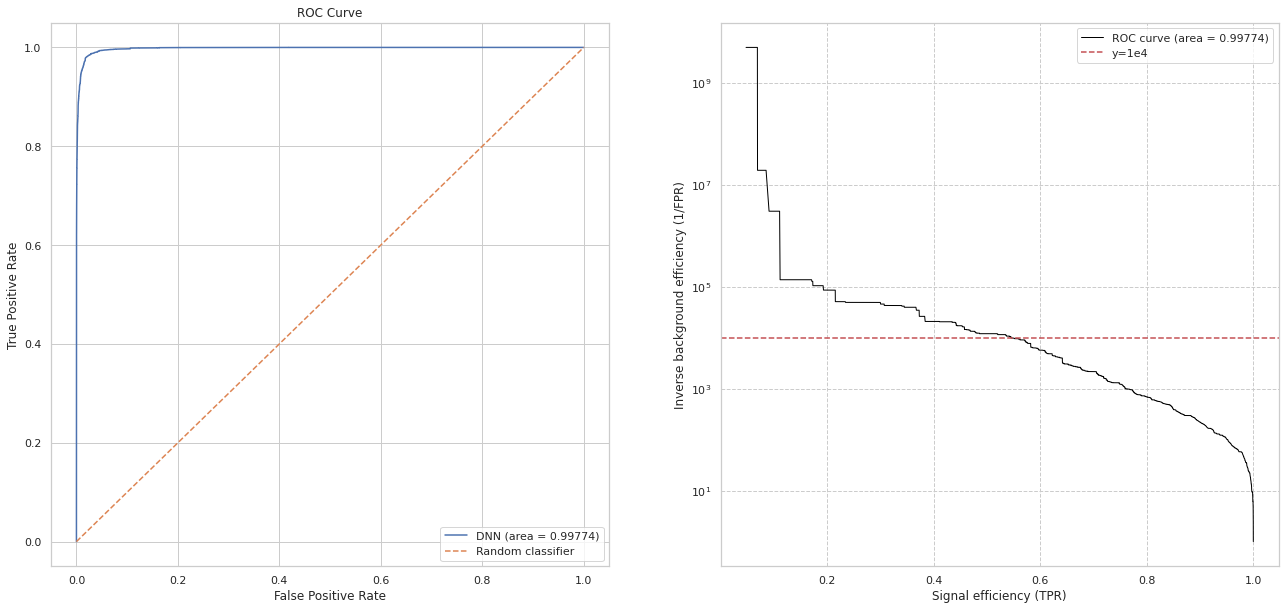

In [19]:
# Plotting ROC Curve
plt.figure(figsize=(22, 10))
plt.subplot(121)
plt.plot(fpr_dnn, tpr_dnn, label='DNN (area = {:.5f})'.format(roc_auc_dnn))
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)

plt.subplot(122)
plt.plot(tpr_dnn, 1/fpr_dnn, color='black', lw=1, label='ROC curve (area = %0.5f)' % roc_auc_dnn)
plt.xlabel('Signal efficiency (TPR)')
plt.ylabel('Inverse background efficiency (1/FPR)')
plt.yscale('log')
# yticks = np.linspace(0, 10e9, 71)
# plt.yticks(yticks, labels=[str(ytick) for ytick in yticks])
plt.axhline(y=1e4, color='r', linestyle='--', label='y=1e4')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


/tmp/ipykernel_530/3730110596.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data.rename(columns=feature_mapping, inplace=True)
/tmp/ipykernel_530/3730110596.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_data.rename(columns=feature_mapping, inplace=True)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.3}
Testing accuracy:  0.9710506516454281


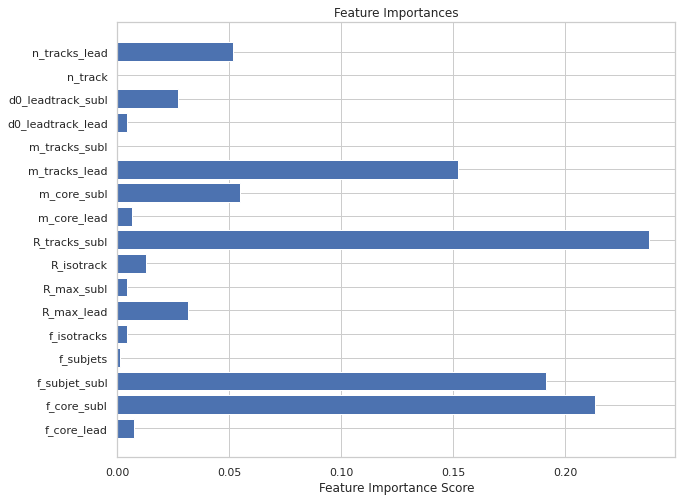

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

training_vars = ["f_core_lead",
                "f_core_subl",
                "f_subjet_subl",
                "f_subjets",
                "f_isotracks",
                "R_max_lead",
                "R_max_subl",
                "R_isotrack",
                "R_tracks_subl",
                "m_core_lead",
                "m_core_subl",
                "m_tracks_lead",
                "m_tracks_subl",
                "d0_leadtrack_lead",
                "d0_leadtrack_subl",
                "n_track",
                "n_tracks_lead"]


# Scrambling
# Calculate the modulo of each eventID with 5
df['eventID_mod'] = df['event_id'] % 10

df['weight'] = df['event_weight'] * df['pT_weight']

log_vars = ["f_isotracks", "m_core_lead", "m_core_subl", "m_tracks_lead", "m_tracks_subl"]
abs_log_var = ["d0_leadtrack_lead", "d0_leadtrack_subl"]

train_df = df[df['eventID_mod'] < 7] # 80%
test_df = df[df['eventID_mod'] >= 7] # 20%

train_df = train_df.drop(columns='eventID_mod')
test_df = test_df.drop(columns='eventID_mod')

# Training & Testing sets
training_data, testing_data, training_labels, testing_labels, training_weights, testing_weights = \
train_df[training_vars], test_df[training_vars], train_df['label'], test_df['label'], train_df['weight'], test_df['weight']

# Change column names to integers if needed (for ML models that expect numerical feature names)
feature_mapping = {feature: i for i, feature in enumerate(training_data.columns)}
training_data.rename(columns=feature_mapping, inplace=True)
testing_data.rename(columns=feature_mapping, inplace=True)

# Define the classifier
bdt = XGBClassifier(random_state=0, verbosity=1)

# Define the parameter distribution
param_dist = {
    'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
    'max_depth': [2, 3, 4, 5, 6]
}

# Define the search with RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=bdt, param_distributions=param_dist, n_iter=10, scoring='accuracy', cv=3, verbose=2, random_state=0, n_jobs=-1)

# Perform the search
random_search.fit(training_data, training_labels, sample_weight=training_weights)

# Best estimator found by RandomizedSearchCV
best_estimator = random_search.best_estimator_

# Predictions and final evaluation on the testing set
predictions = best_estimator.predict(testing_data)
accuracy = accuracy_score(testing_labels, predictions, sample_weight=testing_weights)

# Output the results
print("Best parameters found: ", random_search.best_params_)
print("Testing accuracy: ", accuracy)

# Feature Importance
importance = best_estimator.feature_importances_
# Re-map the feature importance scores to the original feature names
feature_importances = {training_vars[i]: score for i, score in enumerate(importance)}

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(range(len(feature_importances)), list(feature_importances.values()), align='center')
plt.yticks(range(len(feature_importances)), list(feature_importances.keys()))
plt.xlabel('Feature Importance Score')
plt.title('Feature Importances')
plt.show()

Best parameters found:  {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.3}
Testing accuracy after early stopping:  0.9710506516454281


/tmp/ipykernel_530/938927774.py:25: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_dnn, 1/fpr_dnn, lw=1, label='ROC curve (area = %0.5f)' % roc_auc_dnn)
/tmp/ipykernel_530/938927774.py:26: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_bdt, 1/fpr_bdt, lw=1, label='ROC curve (area = %0.5f)' % roc_auc_bdt)


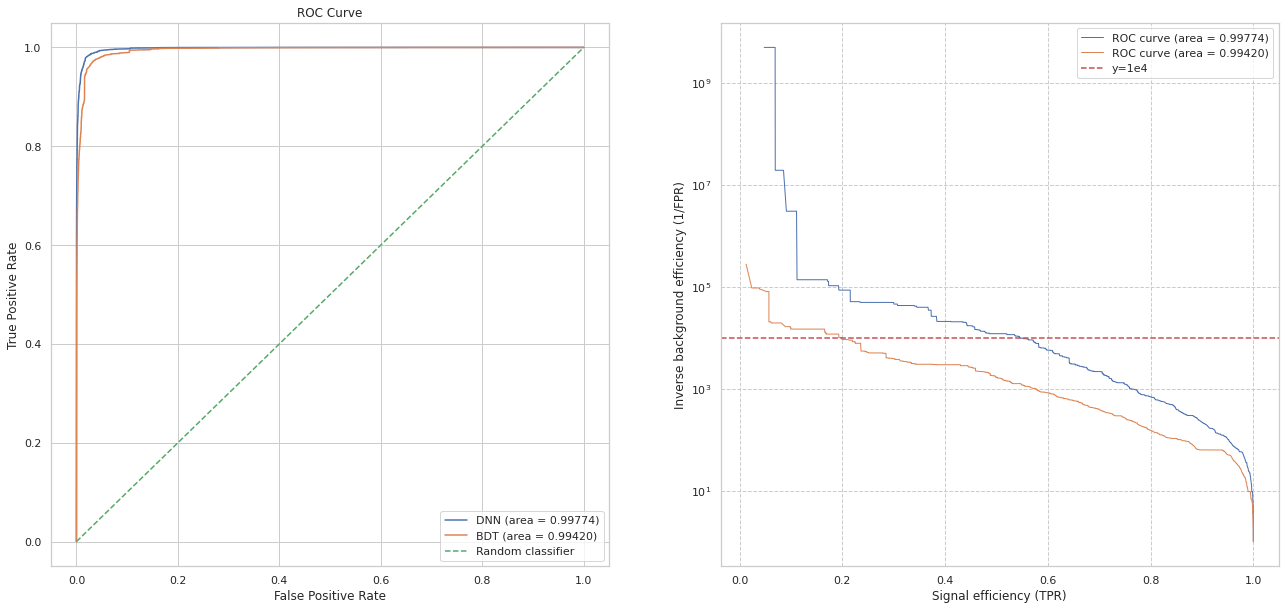

In [21]:
# Output the results
print("Best parameters found: ", random_search.best_params_)
print("Testing accuracy after early stopping: ", accuracy)

# Predict probabilities for the testing data
probs = best_estimator.predict_proba(testing_data)
probs = probs[:, 1]

fpr_bdt, tpr_bdt, thresholds_bdt = roc_curve(testing_labels, probs, sample_weight=testing_weights)
roc_auc_bdt = auc(fpr_bdt, tpr_bdt)

# Plotting ROC Curve
plt.figure(figsize=(22, 10))
plt.subplot(121)
plt.plot(fpr_dnn, tpr_dnn, label='DNN (area = {:.5f})'.format(roc_auc_dnn))
plt.plot(fpr_bdt, tpr_bdt, label='BDT (area = {:.5f})'.format(roc_auc_bdt))
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)

plt.subplot(122)
plt.plot(tpr_dnn, 1/fpr_dnn, lw=1, label='ROC curve (area = %0.5f)' % roc_auc_dnn)
plt.plot(tpr_bdt, 1/fpr_bdt, lw=1, label='ROC curve (area = %0.5f)' % roc_auc_bdt)
plt.xlabel('Signal efficiency (TPR)')
plt.ylabel('Inverse background efficiency (1/FPR)')
plt.yscale('log')
# yticks = np.linspace(0, 10e9, 71)
# plt.yticks(yticks, labels=[str(ytick) for ytick in yticks])
plt.axhline(y=1e4, color='r', linestyle='--', label='y=1e4')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()